<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Yet_another_copy_of_Yet_another_copy_of_Hybrid_pmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [2]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.7997 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=400,
    batch_size=150,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/400
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 55.0631
Epoch 1: val_loss improved from inf to 17.61774, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 54.5337 - val_loss: 17.6177
Epoch 2/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.4045 
Epoch 2: val_loss improved from 17.61774 to 12.46145, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.9339 - val_loss: 12.4615
Epoch 3/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.9887 
Epoch 3: val_loss improved from 12.46145 to 11.68064, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.9334 - val_loss: 11.6806
Epoch 4/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.3691 
Epoch 4: val_loss improved from 11.68064 to 11.17290, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.3219 - val_loss: 11.1729
Epoch 5/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.6257
Epoch 5: val_loss improved from 11.17290 to 10.64492, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.7278 - val_loss: 10.6449
Epoch 6/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.1268
Epoch 6: val_loss improved from 10.64492 to 10.16331, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.1648 - val_loss: 10.1633
Epoch 7/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2241 
Epoch 7: val_loss improved from 10.16331 to 9.63867, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.1161 - val_loss: 9.6387
Epoch 8/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7435 
Epoch 8: val_loss improved from 9.63867 to 9.00028, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6210 - val_loss: 9.0003
Epoch 9/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1580 
Epoch 9: val_loss improved from 9.00028 to 8.13687, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0335 - val_loss: 8.1369
Epoch 10/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6623 
Epoch 10: val_loss improved from 8.13687 to 7.02052, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6637 - val_loss: 7.0205
Epoch 11/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8132 
Epoch 11: val_loss improved from 7.02052 to 5.63866, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7185 - val_loss: 5.6387
Epoch 12/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7649 
Epoch 12: val_loss improved from 5.63866 to 4.77150, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6193 - val_loss: 4.7715
Epoch 13/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8828 
Epoch 13: val_loss improved from 4.77150 to 4.09820, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8154 - val_loss: 4.0982
Epoch 14/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6721 
Epoch 14: val_loss improved from 4.09820 to 3.89626, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5357 - val_loss: 3.8963
Epoch 15/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8762 
Epoch 15: val_loss improved from 3.89626 to 3.59565, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8748 - val_loss: 3.5956
Epoch 16/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3484 
Epoch 16: val_loss improved from 3.59565 to 3.34675, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1697 - val_loss: 3.3467
Epoch 17/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0079 
Epoch 17: val_loss improved from 3.34675 to 3.14641, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1285 - val_loss: 3.1464
Epoch 18/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1734 
Epoch 18: val_loss improved from 3.14641 to 2.96292, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1929 - val_loss: 2.9629
Epoch 19/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6060 
Epoch 19: val_loss improved from 2.96292 to 2.88843, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4130 - val_loss: 2.8884
Epoch 20/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7879 
Epoch 20: val_loss did not improve from 2.88843
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8091 - val_loss: 3.2637
Epoch 21/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6437 
Epoch 21: val_loss improved from 2.88843 to 2.55829, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6979 - val_loss: 2.5583
Epoch 22/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6553 
Epoch 22: val_loss improved from 2.55829 to 2.46973, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6526 - val_loss: 2.4697
Epoch 23/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2974 
Epoch 23: val_loss improved from 2.46973 to 2.34804, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3685 - val_loss: 2.3480
Epoch 24/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4957 
Epoch 24: val_loss did not improve from 2.34804
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4590 - val_loss: 2.3598
Epoch 25/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3045 
Epoch 25: val_loss did not improve from 2.34804
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3002 - val_loss: 2.5060
Epoch 26/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2618 
Epoch 26: val_loss improved from 2.34804 to 2.21280, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2582 - val_loss: 2.2128
Epoch 27/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2495 
Epoch 27: val_loss improved from 2.21280 to 2.00518, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2117 - val_loss: 2.0052
Epoch 28/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9845 
Epoch 28: val_loss improved from 2.00518 to 1.99843, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9800 - val_loss: 1.9984
Epoch 29/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0462 
Epoch 29: val_loss improved from 1.99843 to 1.89359, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0489 - val_loss: 1.8936
Epoch 30/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2472 
Epoch 30: val_loss improved from 1.89359 to 1.85307, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1425 - val_loss: 1.8531
Epoch 31/400
25/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7246 
Epoch 31: val_loss did not improve from 1.85307
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7598 - val_loss: 2.0183
Epoch 32/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6541 
Epoch 32: val_loss improved from 1.85307 to 1.81951, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6903 - val_loss: 1.8195
Epoch 33/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7176 
Epoch 33: val_loss did not improve from 1.81951
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7412 - val_loss: 1.8867
Epoch 34/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6748 
Epoch 34: val_loss improved from 1.81951 to 1.55421, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6740 - val_loss: 1.5542
Epoch 35/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7790 
Epoch 35: val_loss did not improve from 1.55421
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7145 - val_loss: 1.5899
Epoch 36/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4938 
Epoch 36: val_loss did not improve from 1.55421
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5073 - val_loss: 1.9315
Epoch 37/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4441 
Epoch 37: val_loss improved from 1.55421 to 1.44098, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4512 - val_loss: 1.4410
Epoch 38/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5001 
Epoch 38: val_loss improved from 1.44098 to 1.42063, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4730 - val_loss: 1.4206
Epoch 39/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3059 
Epoch 39: val_loss improved from 1.42063 to 1.40835, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3288 - val_loss: 1.4083
Epoch 40/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4612 
Epoch 40: val_loss improved from 1.40835 to 1.38804, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4326 - val_loss: 1.3880
Epoch 41/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2596 
Epoch 41: val_loss improved from 1.38804 to 1.24902, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2582 - val_loss: 1.2490
Epoch 42/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1146 
Epoch 42: val_loss did not improve from 1.24902
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1510 - val_loss: 1.2940
Epoch 43/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1621 
Epoch 43: val_loss did not improve from 1.24902
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1751 - val_loss: 1.5014
Epoch 44/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4192 
Epoch 44: val_loss did not improve from 1.24902
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4273 - val_loss: 1.4442
Epoch 45/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1823 
Epoch 45: val_loss improved from 1.24902 to 1.05315, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1387 - val_loss: 1.0531
Epoch 46/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0136 
Epoch 46: val_loss did not improve from 1.05315
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0099 - val_loss: 1.1859
Epoch 47/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0024 
Epoch 47: val_loss improved from 1.05315 to 1.03822, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0140 - val_loss: 1.0382
Epoch 48/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0166 
Epoch 48: val_loss improved from 1.03822 to 0.93033, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0208 - val_loss: 0.9303
Epoch 49/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9735 
Epoch 49: val_loss improved from 0.93033 to 0.92329, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0041 - val_loss: 0.9233
Epoch 50/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8362 
Epoch 50: val_loss did not improve from 0.92329
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8656 - val_loss: 1.0351
Epoch 51/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9076 
Epoch 51: val_loss did not improve from 0.92329
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9687 - val_loss: 1.0631
Epoch 52/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8791 
Epoch 52: val_loss did not improve from 0.92329
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9170 - val_loss: 2.3165
Epoch 53/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3212 
Epoch 53: val_loss improved from 0.92329 to 0.88962, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2215 - val_loss: 0.8896
Epoch 54/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7778 
Epoch 54: val_loss improved from 0.88962 to 0.72154, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7688 - val_loss: 0.7215
Epoch 55/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8339 
Epoch 55: val_loss did not improve from 0.72154
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8519 - val_loss: 0.9773
Epoch 56/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6821 
Epoch 56: val_loss improved from 0.72154 to 0.70823, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6925 - val_loss: 0.7082
Epoch 57/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6978 
Epoch 57: val_loss did not improve from 0.70823
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6736 - val_loss: 0.7096
Epoch 58/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6957 
Epoch 58: val_loss improved from 0.70823 to 0.63176, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7085 - val_loss: 0.6318
Epoch 59/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5535 
Epoch 59: val_loss did not improve from 0.63176
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5589 - val_loss: 0.7083
Epoch 60/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8466 
Epoch 60: val_loss improved from 0.63176 to 0.59687, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8344 - val_loss: 0.5969
Epoch 61/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5958 
Epoch 61: val_loss improved from 0.59687 to 0.59572, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5896 - val_loss: 0.5957
Epoch 62/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6561 
Epoch 62: val_loss did not improve from 0.59572
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6346 - val_loss: 0.6130
Epoch 63/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4768 
Epoch 63: val_loss did not improve from 0.59572
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4688 - val_loss: 0.5977
Epoch 64/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4518 
Epoch 64: val_loss improved from 0.59572 to 0.53157, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4959 - val_loss: 0.5316
Epoch 65/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5317 
Epoch 65: val_loss did not improve from 0.53157
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5243 - val_loss: 1.1930
Epoch 66/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8761 
Epoch 66: val_loss improved from 0.53157 to 0.45032, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8373 - val_loss: 0.4503
Epoch 67/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3794 
Epoch 67: val_loss did not improve from 0.45032
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4062 - val_loss: 0.6635
Epoch 68/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4678 
Epoch 68: val_loss did not improve from 0.45032
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4531 - val_loss: 0.5238
Epoch 69/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3854 
Epoch 69: val_loss did not improve from 0.45032
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3884 - val_loss: 2.3600
Epoch 70/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5833 
Epoch 70: val_loss improved from 0.45032 to 0.41886, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4290 - val_loss: 0.4189
Epoch 71/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3840 
Epoch 71: val_loss did not improve from 0.41886
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4040 - val_loss: 0.6033
Epoch 72/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3741 
Epoch 72: val_loss did not improve from 0.41886
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3755 - val_loss: 0.4390
Epoch 73/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4329 
Epoch 73: val_loss improved from 0.41886 to 0.37272, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4319 - val_loss: 0.3727
Epoch 74/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3410 
Epoch 74: val_loss did not improve from 0.37272
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3375 - val_loss: 0.5147
Epoch 75/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3780 
Epoch 75: val_loss improved from 0.37272 to 0.36966, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3642 - val_loss: 0.3697
Epoch 76/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3540 
Epoch 76: val_loss improved from 0.36966 to 0.35711, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3472 - val_loss: 0.3571
Epoch 77/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4116 
Epoch 77: val_loss improved from 0.35711 to 0.34038, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3986 - val_loss: 0.3404
Epoch 78/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2979 
Epoch 78: val_loss improved from 0.34038 to 0.29329, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2978 - val_loss: 0.2933
Epoch 79/400
25/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2798 
Epoch 79: val_loss did not improve from 0.29329
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2872 - val_loss: 0.3406
Epoch 80/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2872 
Epoch 80: val_loss improved from 0.29329 to 0.27158, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2810 - val_loss: 0.2716
Epoch 81/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2689 
Epoch 81: val_loss did not improve from 0.27158
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2715 - val_loss: 0.3364
Epoch 82/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2961 
Epoch 82: val_loss did not improve from 0.27158
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2912 - val_loss: 0.4745
Epoch 83/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2829 
Epoch 83: val_loss did not improve from 0.27158
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2838 - val_loss: 0.3828
Epoch 84/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2900 
Epoch 84: val_loss did not improve from 0.27158
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2927 - val_loss: 0.4197
Epoch 85/400
25/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2872 
Epoch 85: val_loss improved from 0.27158 to 0.25302, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2748 - val_loss: 0.2530
Epoch 86/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2705 
Epoch 86: val_loss did not improve from 0.25302
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2950 - val_loss: 0.3033
Epoch 87/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2666 
Epoch 87: val_loss did not improve from 0.25302
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2571 - val_loss: 0.2655
Epoch 88/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2115 
Epoch 88: val_loss did not improve from 0.25302
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2167 - val_loss: 0.2706
Epoch 89/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2639 
Epoch 89: val_loss did not improve from 0.25302
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2643 - val_loss: 0.2598
Epoch 90/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2424 
Epoch 90: val_loss improved from 0.25302 to 0.25150, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2470 - val_loss: 0.2515
Epoch 91/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2231 
Epoch 91: val_loss did not improve from 0.25150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2250 - val_loss: 0.3848
Epoch 92/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2449 
Epoch 92: val_loss did not improve from 0.25150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2393 - val_loss: 0.2557
Epoch 93/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2226 
Epoch 93: val_loss improved from 0.25150 to 0.21376, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2187 - val_loss: 0.2138
Epoch 94/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2040 
Epoch 94: val_loss did not improve from 0.21376
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2047 - val_loss: 0.2494
Epoch 95/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2200 
Epoch 95: val_loss did not improve from 0.21376
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2161 - val_loss: 0.2862
Epoch 96/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2474 
Epoch 96: val_loss did not improve from 0.21376
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2448 - val_loss: 0.4456
Epoch 97/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3490 
Epoch 97: val_loss did not improve from 0.21376
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3299 - val_loss: 0.3208
Epoch 98/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3249 
Epoch 98: val_loss did not improve from 0.21376
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3330 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2141 - val_loss: 0.1943
Epoch 101/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1962 
Epoch 101: val_loss did not improve from 0.19426
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1981 - val_loss: 0.1993
Epoch 102/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2056 
Epoch 102: val_loss did not improve from 0.19426
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2031 - val_loss: 0.2400
Epoch 103/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2007 
Epoch 103: val_loss did not improve from 0.19426
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1987 - val_loss: 0.2977
Epoch 104/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2869 
Epoch 104: val_loss did not improve from 0.19426
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2846 - val_loss: 0.2391
Epoch 105/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2217 
Epoch 105: val_loss improved from 0.19426 to 0.19060, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2145 - val_loss: 0.1906
Epoch 106/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1961 
Epoch 106: val_loss did not improve from 0.19060
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1967 - val_loss: 0.1917
Epoch 107/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1918 
Epoch 107: val_loss did not improve from 0.19060
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1924 - val_loss: 0.2004
Epoch 108/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1802 
Epoch 108: val_loss improved from 0.19060 to 0.18294, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1830 - val_loss: 0.1829
Epoch 109/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1800 
Epoch 109: val_loss did not improve from 0.18294
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1825 - val_loss: 0.1920
Epoch 110/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1958 
Epoch 110: val_loss did not improve from 0.18294
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1958 - val_loss: 0.1874
Epoch 111/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1845 
Epoch 111: val_loss did not improve from 0.18294
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2049 - val_loss: 0.3826
Epoch 112/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2868 
Epoch 112: val_loss did not improve from 0.18294
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2682 - val_loss: 0.1949
Epoch 113/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1773 
Epoch 113: val_loss improved from 0.18294 to 0.17598, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1787 - val_loss: 0.1760
Epoch 114/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1897 
Epoch 114: val_loss did not improve from 0.17598
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1906 - val_loss: 0.1868
Epoch 115/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1921 
Epoch 115: val_loss did not improve from 0.17598
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1892 - val_loss: 0.1918
Epoch 116/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1893 
Epoch 116: val_loss did not improve from 0.17598
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1905 - val_loss: 0.1878
Epoch 117/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1836 
Epoch 117: val_loss did not improve from 0.17598
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1883 - val_loss: 0.1949
Epoch 118/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1969 
Epoch 118: val_loss did not improve from 0.17598
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1739 - val_loss: 0.1701
Epoch 126/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1637 
Epoch 126: val_loss did not improve from 0.17007
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1656 - val_loss: 0.1704
Epoch 127/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1764 
Epoch 127: val_loss did not improve from 0.17007
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1748 - val_loss: 0.1714
Epoch 128/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1731 
Epoch 128: val_loss improved from 0.17007 to 0.16867, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1708 - val_loss: 0.1687
Epoch 129/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1694 
Epoch 129: val_loss did not improve from 0.16867
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1728 - val_loss: 0.1859
Epoch 130/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1708 
Epoch 130: val_loss improved from 0.16867 to 0.16746, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1699 - val_loss: 0.1675
Epoch 131/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1717 
Epoch 131: val_loss did not improve from 0.16746
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1742 - val_loss: 0.1743
Epoch 132/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1781 
Epoch 132: val_loss did not improve from 0.16746
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1761 - val_loss: 0.1845
Epoch 133/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1559 
Epoch 133: val_loss did not improve from 0.16746
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1590 - val_loss: 0.1788
Epoch 134/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1703 
Epoch 134: val_loss did not improve from 0.16746
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1703 - val_loss: 0.1958
Epoch 135/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1749 
Epoch 135: val_loss did not improve from 0.16746
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1708 - val_loss: 0.1644
Epoch 137/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1672 
Epoch 137: val_loss improved from 0.16437 to 0.16340, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1652 - val_loss: 0.1634
Epoch 138/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1646 
Epoch 138: val_loss improved from 0.16340 to 0.16065, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1632 - val_loss: 0.1606
Epoch 139/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1581 
Epoch 139: val_loss did not improve from 0.16065
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1579 - val_loss: 0.1622
Epoch 140/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1794 
Epoch 140: val_loss did not improve from 0.16065
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1768 - val_loss: 0.1645
Epoch 141/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1787 
Epoch 141: val_loss did not improve from 0.16065
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1742 - val_loss: 0.1666
Epoch 142/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1650 
Epoch 142: val_loss did not improve from 0.16065
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1667 - val_loss: 0.1820
Epoch 143/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1777 
Epoch 143: val_loss did not improve from 0.16065
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1587 - val_loss: 0.1581
Epoch 152/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1638 
Epoch 152: val_loss did not improve from 0.15812
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1640 - val_loss: 0.1610
Epoch 153/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1750 
Epoch 153: val_loss improved from 0.15812 to 0.15777, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1723 - val_loss: 0.1578
Epoch 154/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1506 
Epoch 154: val_loss did not improve from 0.15777
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1515 - val_loss: 0.1748
Epoch 155/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1647 
Epoch 155: val_loss improved from 0.15777 to 0.15597, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1623 - val_loss: 0.1560
Epoch 156/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1624 
Epoch 156: val_loss did not improve from 0.15597
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1613 - val_loss: 0.1732
Epoch 157/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1695 
Epoch 157: val_loss did not improve from 0.15597
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1725 - val_loss: 0.1930
Epoch 158/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1813 
Epoch 158: val_loss did not improve from 0.15597
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1766 - val_loss: 0.1650
Epoch 159/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1575 
Epoch 159: val_loss did not improve from 0.15597
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1569 - val_loss: 0.1570
Epoch 160/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1604 
Epoch 160: val_loss did not improve from 0.15597
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1623 - val_loss: 0.1516
Epoch 171/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1555 
Epoch 171: val_loss did not improve from 0.15155
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1551 - val_loss: 0.1803
Epoch 172/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1630 
Epoch 172: val_loss did not improve from 0.15155
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1634 - val_loss: 0.1781
Epoch 173/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1555 
Epoch 173: val_loss did not improve from 0.15155
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1574 - val_loss: 0.1539
Epoch 174/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1498 
Epoch 174: val_loss did not improve from 0.15155
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1501 - val_loss: 0.1526
Epoch 175/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1450 
Epoch 175: val_loss did not improve from 0.15155
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1695 - val_loss: 0.1515
Epoch 179/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503 
Epoch 179: val_loss did not improve from 0.15150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1545 - val_loss: 0.1568
Epoch 180/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1520 
Epoch 180: val_loss did not improve from 0.15150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1523 - val_loss: 0.1682
Epoch 181/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503 
Epoch 181: val_loss improved from 0.15150 to 0.14725, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1518 - val_loss: 0.1473
Epoch 182/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1714 
Epoch 182: val_loss did not improve from 0.14725
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1781 - val_loss: 0.1916
Epoch 183/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1851 
Epoch 183: val_loss did not improve from 0.14725
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1817 - val_loss: 0.1639
Epoch 184/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1579 
Epoch 184: val_loss did not improve from 0.14725
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1566 - val_loss: 0.1501
Epoch 185/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1525 
Epoch 185: val_loss did not improve from 0.14725
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1541 - val_loss: 0.1507
Epoch 186/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1576 
Epoch 186: val_loss did not improve from 0.14725
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1564 - val_loss: 0.1470
Epoch 195/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1484 
Epoch 195: val_loss did not improve from 0.14697
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1479 - val_loss: 0.1488
Epoch 196/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1536 
Epoch 196: val_loss did not improve from 0.14697
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1552 - val_loss: 0.1599
Epoch 197/400
30/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1500 
Epoch 197: val_loss did not improve from 0.14697
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1502 - val_loss: 0.1494
Epoch 198/400
30/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1598 
Epoch 198: val_loss did not improve from 0.14697
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1617 - val_loss: 0.1545
Epoch 199/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1477 
Epoch 199: val_loss did not improve from 0.14697
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1497 - val_loss: 0.1462
Epoch 203/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 203: val_loss did not improve from 0.14618
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1398 - val_loss: 0.1516
Epoch 204/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2598 
Epoch 204: val_loss did not improve from 0.14618
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6662 - val_loss: 3.2529
Epoch 205/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9483 
Epoch 205: val_loss did not improve from 0.14618
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8516 - val_loss: 0.8339
Epoch 206/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1627 
Epoch 206: val_loss did not improve from 0.14618
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2048 - val_loss: 1.1222
Epoch 207/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9400 
Epoch 207: val_loss did not improve from 0.14618
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1467 - val_loss: 0.1461
Epoch 233/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1400 
Epoch 233: val_loss did not improve from 0.14611
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1410 - val_loss: 0.1476
Epoch 234/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1486 
Epoch 234: val_loss did not improve from 0.14611
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1480 - val_loss: 0.1504
Epoch 235/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1412 
Epoch 235: val_loss improved from 0.14611 to 0.14495, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1430 - val_loss: 0.1450
Epoch 236/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1441 
Epoch 236: val_loss did not improve from 0.14495
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1436 - val_loss: 0.1450
Epoch 237/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1356 
Epoch 237: val_loss improved from 0.14495 to 0.14494, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1378 - val_loss: 0.1449
Epoch 238/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1522 
Epoch 238: val_loss did not improve from 0.14494
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1503 - val_loss: 0.1455
Epoch 239/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1465 
Epoch 239: val_loss improved from 0.14494 to 0.14419, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1459 - val_loss: 0.1442
Epoch 240/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1386 
Epoch 240: val_loss improved from 0.14419 to 0.14412, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1397 - val_loss: 0.1441
Epoch 241/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1461 
Epoch 241: val_loss did not improve from 0.14412
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1458 - val_loss: 0.1449
Epoch 242/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1412 
Epoch 242: val_loss did not improve from 0.14412
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1421 - val_loss: 0.1449
Epoch 243/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1438 
Epoch 243: val_loss did not improve from 0.14412
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1437 - val_loss: 0.1450
Epoch 244/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1393 
Epoch 244: val_loss did not improve from 0.14412
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1409 - val_loss: 0.1520
Epoch 245/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1628 
Epoch 245: val_loss did not improve from 0.14412
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1429 - val_loss: 0.1439
Epoch 248/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1467 
Epoch 248: val_loss improved from 0.14393 to 0.14326, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1462 - val_loss: 0.1433
Epoch 249/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1359 
Epoch 249: val_loss did not improve from 0.14326
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1373 - val_loss: 0.1442
Epoch 250/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1376 
Epoch 250: val_loss did not improve from 0.14326
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1389 - val_loss: 0.1442
Epoch 251/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1471 
Epoch 251: val_loss did not improve from 0.14326
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1455 - val_loss: 0.1434
Epoch 252/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1359 
Epoch 252: val_loss did not improve from 0.14326
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1378 - val_loss: 0.1457
Epoch 253/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1540 
Epoch 253: val_loss did not improve from 0.14326
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1430 - val_loss: 0.1428
Epoch 255/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1510 
Epoch 255: val_loss did not improve from 0.14280
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1497 - val_loss: 0.1433
Epoch 256/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1445 
Epoch 256: val_loss did not improve from 0.14280
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1442 - val_loss: 0.1476
Epoch 257/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1491 
Epoch 257: val_loss did not improve from 0.14280
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1480 - val_loss: 0.1464
Epoch 258/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1396 
Epoch 258: val_loss improved from 0.14280 to 0.14231, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1411 - val_loss: 0.1423
Epoch 259/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1482 
Epoch 259: val_loss did not improve from 0.14231
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1477 - val_loss: 0.1476
Epoch 260/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1453 
Epoch 260: val_loss did not improve from 0.14231
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1436 - val_loss: 0.1440
Epoch 261/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1440 
Epoch 261: val_loss did not improve from 0.14231
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1445 - val_loss: 0.1461
Epoch 262/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1552 
Epoch 262: val_loss did not improve from 0.14231
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1525 - val_loss: 0.1455
Epoch 263/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 
Epoch 263: val_loss did not improve from 0.14231
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1372 - val_loss: 0.1416
Epoch 265/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1435 
Epoch 265: val_loss did not improve from 0.14157
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1433 - val_loss: 0.1428
Epoch 266/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1439 
Epoch 266: val_loss did not improve from 0.14157
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1436 - val_loss: 0.1489
Epoch 267/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1484 
Epoch 267: val_loss did not improve from 0.14157
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1468 - val_loss: 0.1421
Epoch 268/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1437 
Epoch 268: val_loss did not improve from 0.14157
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1429 - val_loss: 0.1447
Epoch 269/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1455 
Epoch 269: val_loss did not improve from 0.14157
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1369 - val_loss: 0.1412
Epoch 276/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1472 
Epoch 276: val_loss did not improve from 0.14118
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1457 - val_loss: 0.1421
Epoch 277/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1336 
Epoch 277: val_loss did not improve from 0.14118
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1354 - val_loss: 0.1441
Epoch 278/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1486 
Epoch 278: val_loss did not improve from 0.14118
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1482 - val_loss: 0.1463
Epoch 279/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1474 
Epoch 279: val_loss improved from 0.14118 to 0.14059, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1473 - val_loss: 0.1406
Epoch 280/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1450 
Epoch 280: val_loss did not improve from 0.14059
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1452 - val_loss: 0.1501
Epoch 281/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1397 
Epoch 281: val_loss did not improve from 0.14059
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1401 - val_loss: 0.1412
Epoch 282/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 
Epoch 282: val_loss did not improve from 0.14059
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1394 - val_loss: 0.1431
Epoch 283/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1401 
Epoch 283: val_loss did not improve from 0.14059
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1413 - val_loss: 0.1655
Epoch 284/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1516 
Epoch 284: val_loss did not improve from 0.14059
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1427 - val_loss: 0.1406
Epoch 286/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1517 
Epoch 286: val_loss did not improve from 0.14057
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1500 - val_loss: 0.1456
Epoch 287/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1451 
Epoch 287: val_loss did not improve from 0.14057
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1434 - val_loss: 0.1471
Epoch 288/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1441 
Epoch 288: val_loss did not improve from 0.14057
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1442 - val_loss: 0.1441
Epoch 289/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1507 
Epoch 289: val_loss did not improve from 0.14057
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1488 - val_loss: 0.1431
Epoch 290/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1324 
Epoch 290: val_loss improved from 0.14057 to 0.14048, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1339 - val_loss: 0.1405
Epoch 291/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1396 
Epoch 291: val_loss did not improve from 0.14048
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1399 - val_loss: 0.1465
Epoch 292/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1497 
Epoch 292: val_loss did not improve from 0.14048
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1472 - val_loss: 0.1447
Epoch 293/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1441 
Epoch 293: val_loss did not improve from 0.14048
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1443 - val_loss: 0.1483
Epoch 294/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1460 
Epoch 294: val_loss did not improve from 0.14048
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1476 - val_loss: 0.1432
Epoch 295/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1474 
Epoch 295: val_loss did not improve from 0.14048
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1460 - val_loss: 0.1384
Epoch 299/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1413 
Epoch 299: val_loss did not improve from 0.13838
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1412 - val_loss: 0.1430
Epoch 300/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1480 
Epoch 300: val_loss did not improve from 0.13838
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1459 - val_loss: 0.1392
Epoch 301/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1345 
Epoch 301: val_loss did not improve from 0.13838
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1362 - val_loss: 0.1390
Epoch 302/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1405 
Epoch 302: val_loss did not improve from 0.13838
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1408 - val_loss: 0.1384
Epoch 303/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1352 
Epoch 303: val_loss did not improve from 0.13838
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1448 - val_loss: 0.1380
Epoch 305/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1374 
Epoch 305: val_loss did not improve from 0.13797
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1390 - val_loss: 0.1608
Epoch 306/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1457 
Epoch 306: val_loss did not improve from 0.13797
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1461 - val_loss: 0.1441
Epoch 307/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1512 
Epoch 307: val_loss did not improve from 0.13797
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1500 - val_loss: 0.1413
Epoch 308/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1397 
Epoch 308: val_loss did not improve from 0.13797
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1408 - val_loss: 0.1390
Epoch 309/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1422 
Epoch 309: val_loss did not improve from 0.13797
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1425 - val_loss: 0.1378
Epoch 313/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1341 
Epoch 313: val_loss did not improve from 0.13777
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1374 - val_loss: 0.1390
Epoch 314/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1423 
Epoch 314: val_loss did not improve from 0.13777
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1428 - val_loss: 0.1459
Epoch 315/400
26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1381 
Epoch 315: val_loss did not improve from 0.13777
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1383 - val_loss: 0.1416
Epoch 316/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1348 
Epoch 316: val_loss did not improve from 0.13777
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1361 - val_loss: 0.1397
Epoch 317/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1370 
Epoch 317: val_loss did not improve from 0.13777
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1369 - val_loss: 0.1369
Epoch 322/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 
Epoch 322: val_loss did not improve from 0.13693
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1390 - val_loss: 0.1425
Epoch 323/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1468 
Epoch 323: val_loss did not improve from 0.13693
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1486 - val_loss: 0.1572
Epoch 324/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1438 
Epoch 324: val_loss did not improve from 0.13693
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1445 - val_loss: 0.1383
Epoch 325/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1341 
Epoch 325: val_loss did not improve from 0.13693
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1361 - val_loss: 0.1422
Epoch 326/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 
Epoch 326: val_loss did not improve from 0.13693
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1455 - val_loss: 0.1366
Epoch 347/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1453 
Epoch 347: val_loss improved from 0.13658 to 0.13580, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1451 - val_loss: 0.1358
Epoch 348/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1284 
Epoch 348: val_loss did not improve from 0.13580
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1307 - val_loss: 0.1377
Epoch 349/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1378 
Epoch 349: val_loss did not improve from 0.13580
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1369 - val_loss: 0.1381
Epoch 350/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1394 
Epoch 350: val_loss did not improve from 0.13580
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1392 - val_loss: 0.1408
Epoch 351/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1409 
Epoch 351: val_loss did not improve from 0.13580
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1397 - val_loss: 0.1370
Epoch 352/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1352 
Epoch 352: val_loss did not improve from 0.13580
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1366 - val_loss: 0.1356
Epoch 392/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362 
Epoch 392: val_loss did not improve from 0.13560
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1366 - val_loss: 0.1363
Epoch 393/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1340 
Epoch 393: val_loss did not improve from 0.13560
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1350 - val_loss: 0.1358
Epoch 394/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1314 
Epoch 394: val_loss did not improve from 0.13560
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1320 - val_loss: 0.1376
Epoch 395/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 
Epoch 395: val_loss did not improve from 0.13560
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1401 - val_loss: 0.1388
Epoch 396/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1388 
Epoch 396: val_loss improved from 0.13560 to 0.13481, saving model to best_final_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1387 - val_loss: 0.1348
Epoch 397/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1429 
Epoch 397: val_loss did not improve from 0.13481
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1406 - val_loss: 0.1357
Epoch 398/400
28/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1434 
Epoch 398: val_loss did not improve from 0.13481
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1431 - val_loss: 0.1382
Epoch 399/400
27/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1424 
Epoch 399: val_loss did not improve from 0.13481
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1409 - val_loss: 0.1374
Epoch 400/400
29/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 
Epoch 400: val_loss did not improve from 0.13481
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1371 - val_loss: 0.1351


In [14]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Final NN I_ds → MSE: 3.7798e-11, R²: 0.9991
Final gm → MSE: 1.3910e-11, R²: 0.9992
Final gd → MSE: 6.0012e-11, R²: 0.9959


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


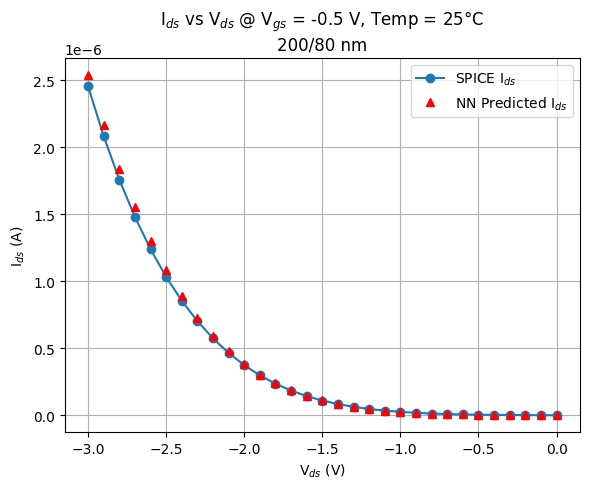

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


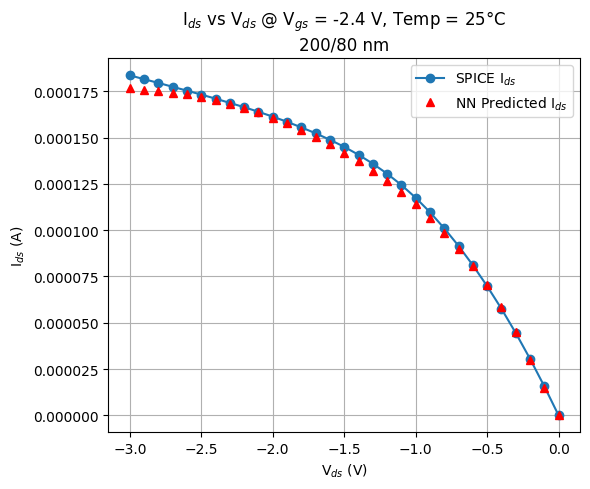

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


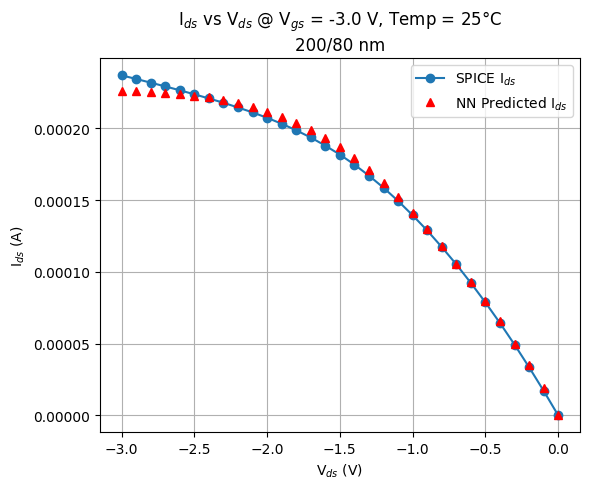

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


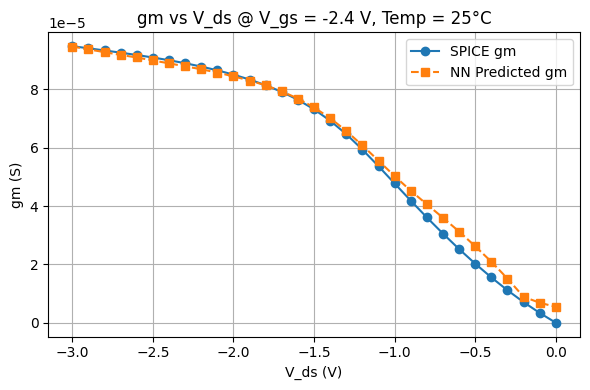

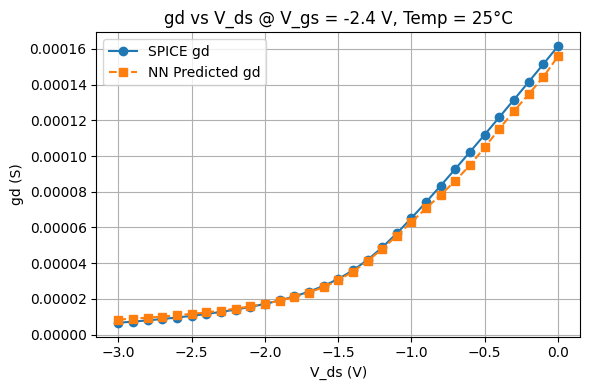

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


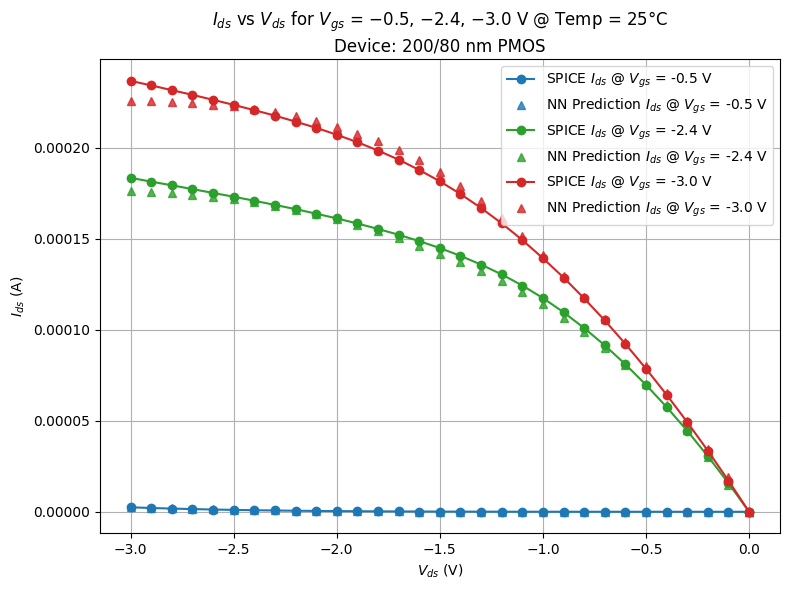

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


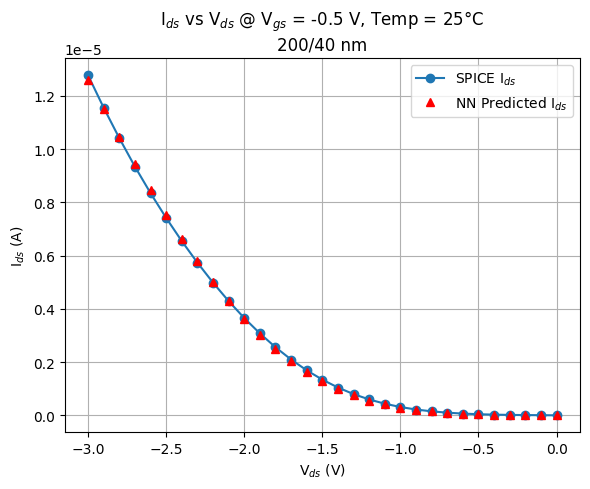

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


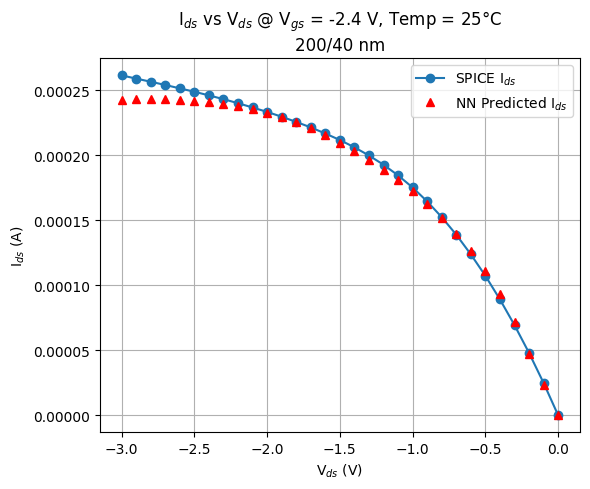

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


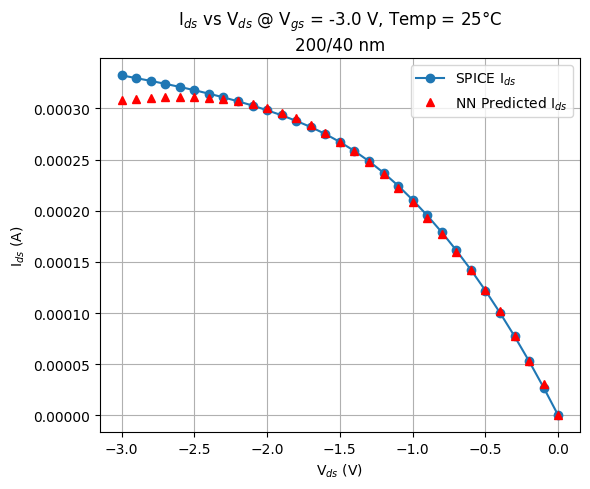

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


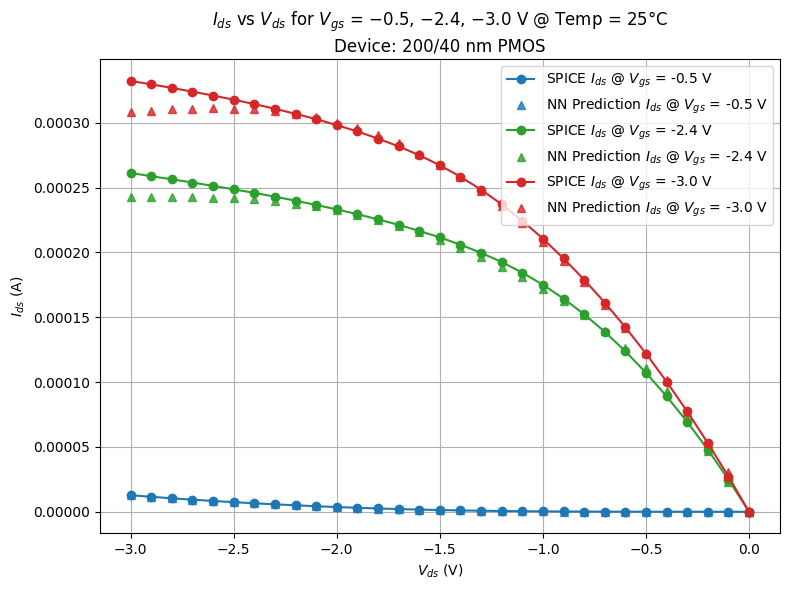

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


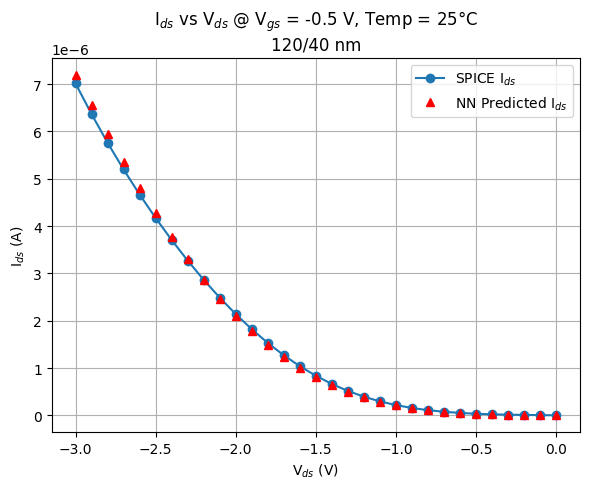

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


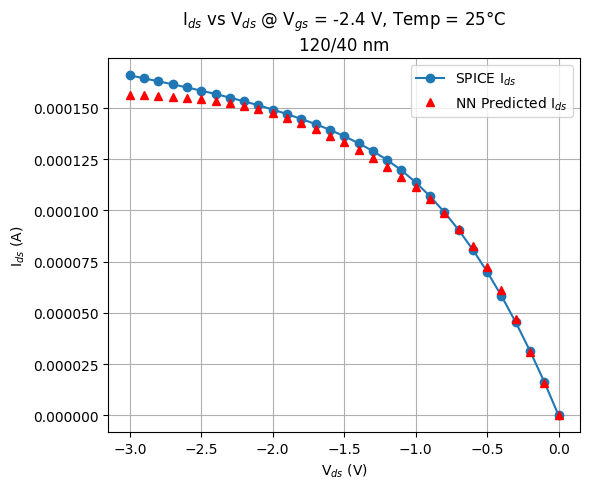

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


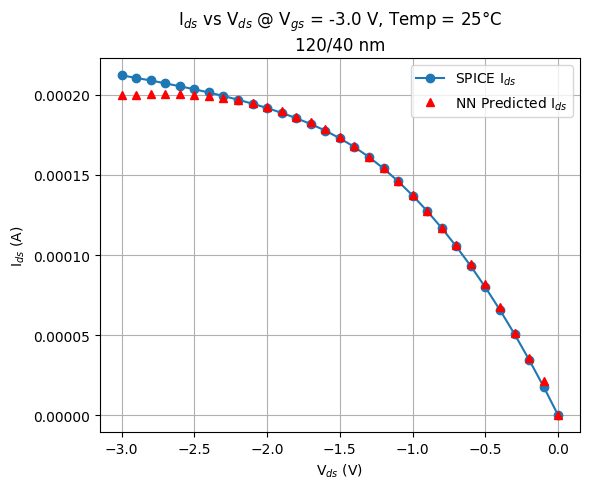

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


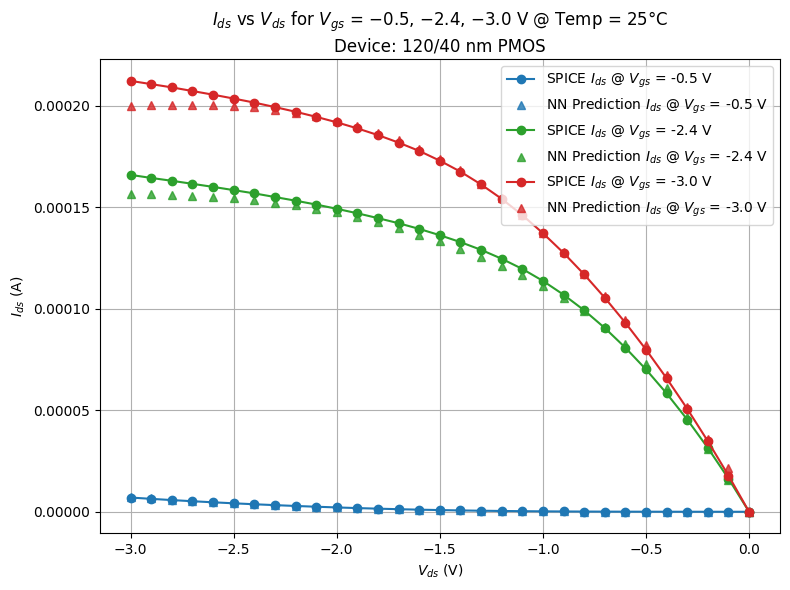

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


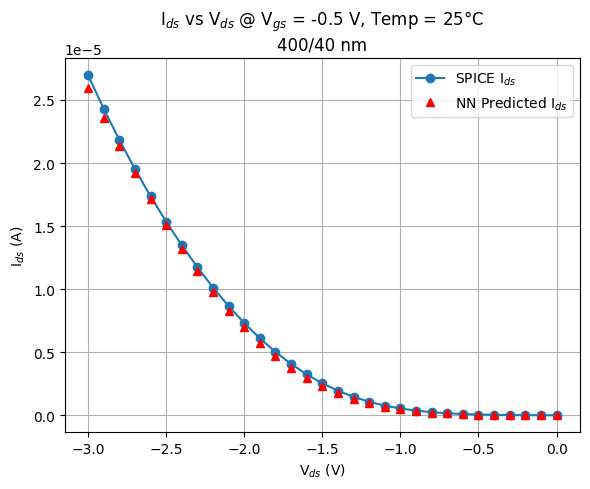

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


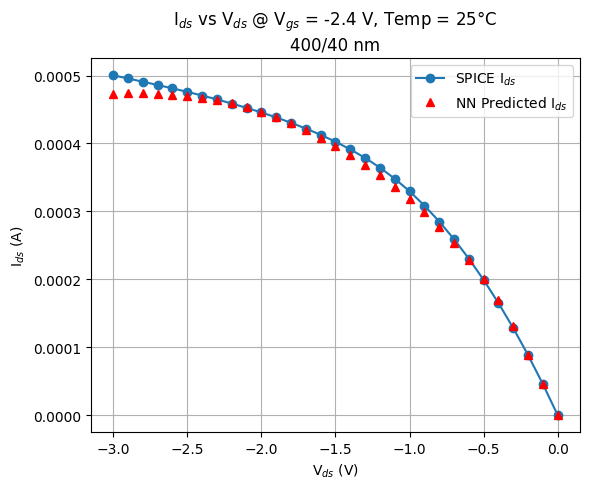

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


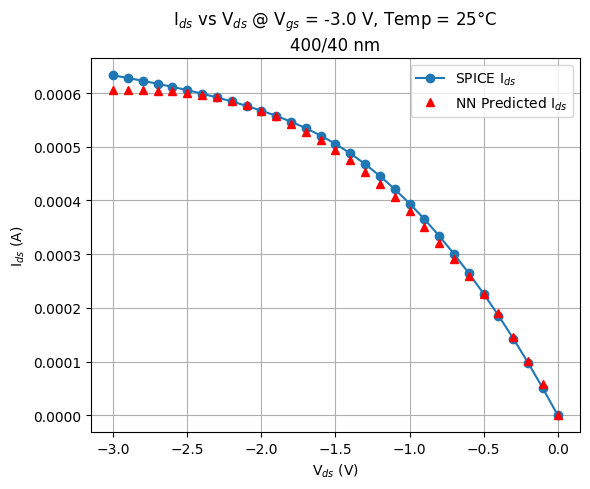

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


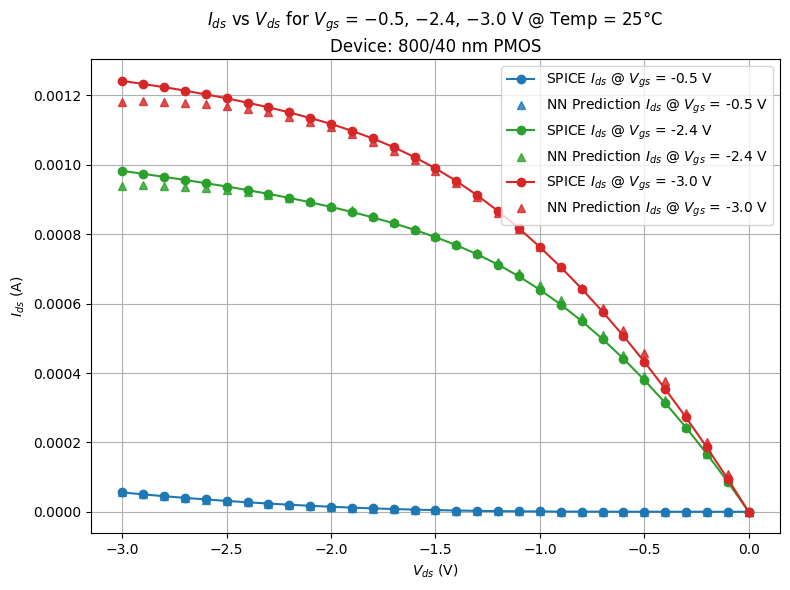

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


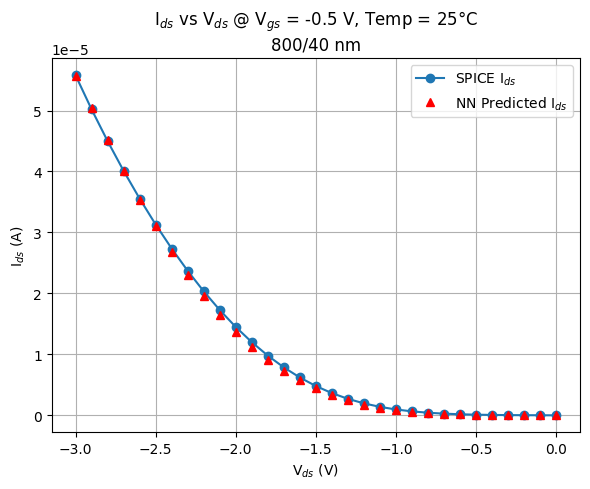

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


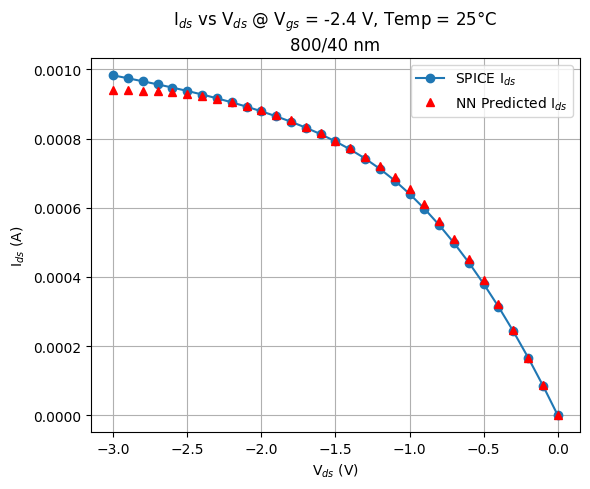

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


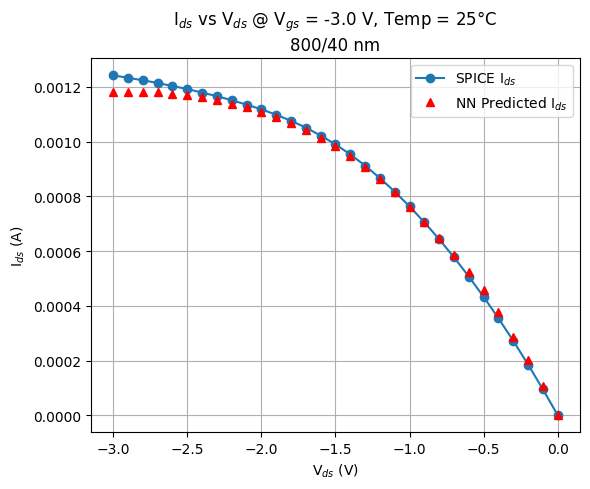

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


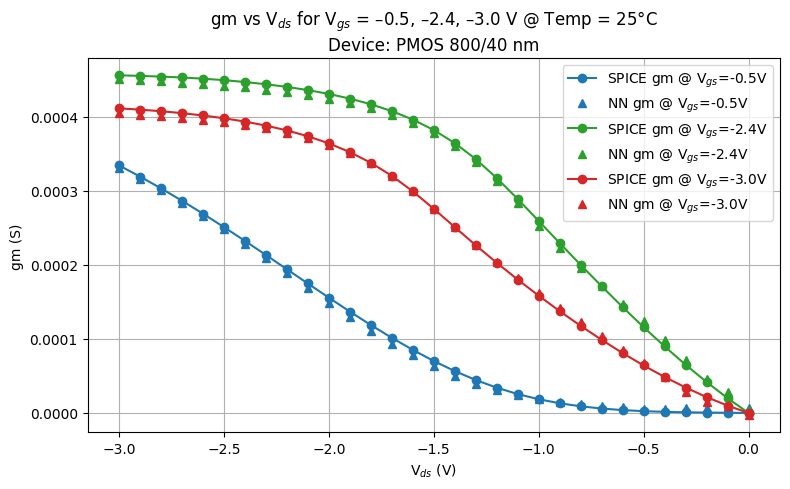

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x500 with 0 Axes>

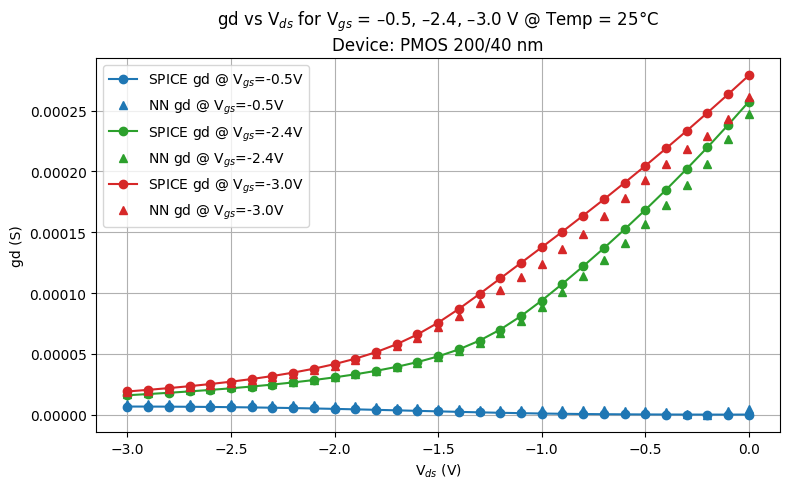

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<Figure size 800x500 with 0 Axes>

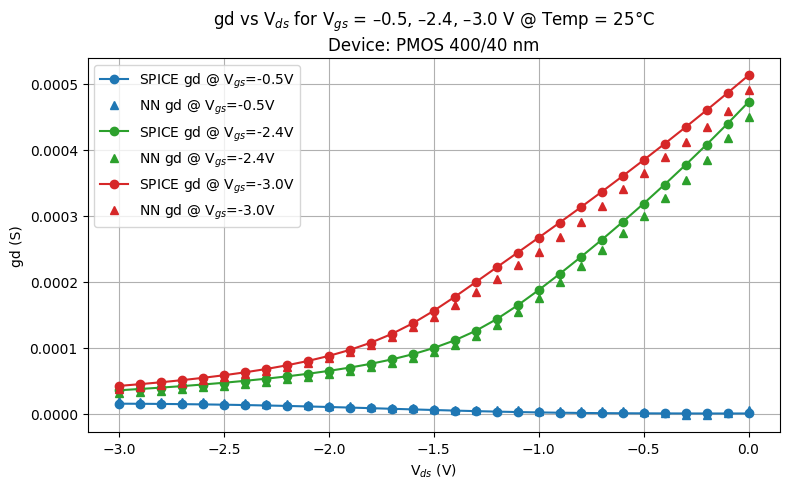

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 800x500 with 0 Axes>

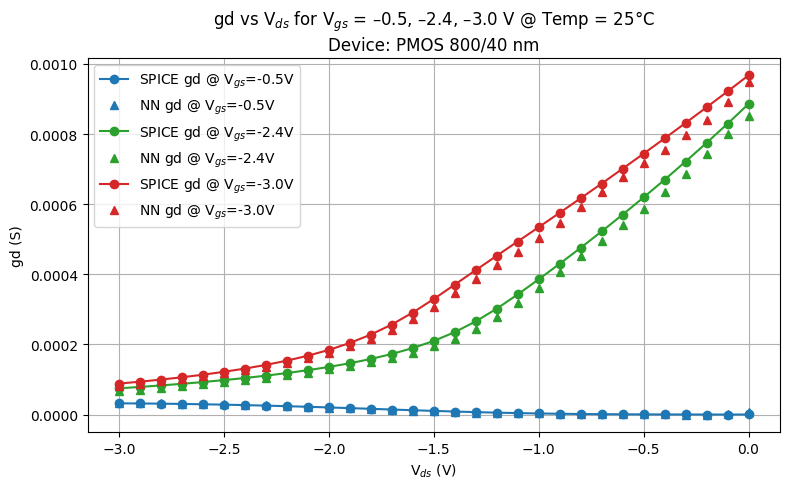

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


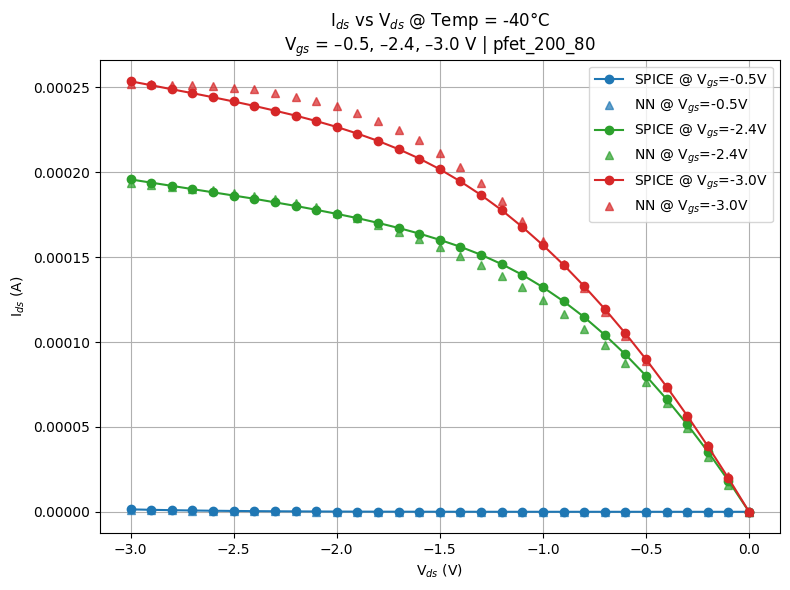

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


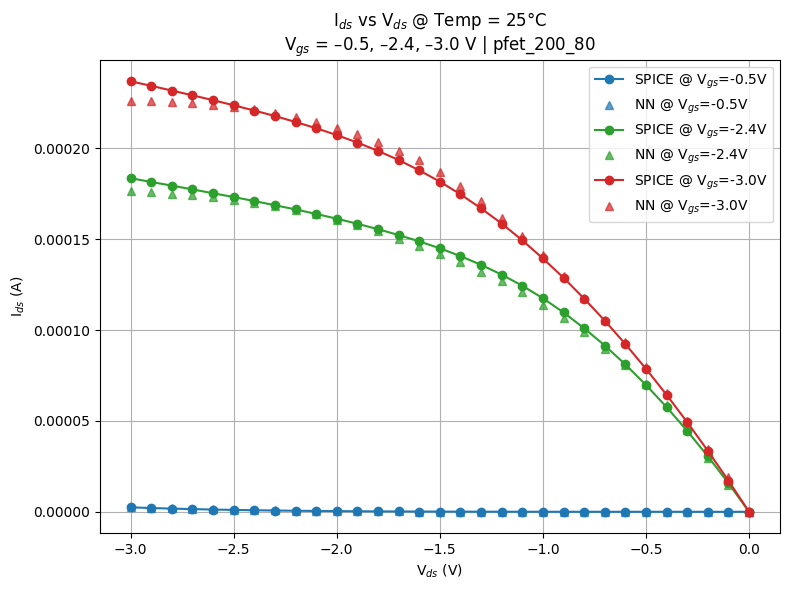

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


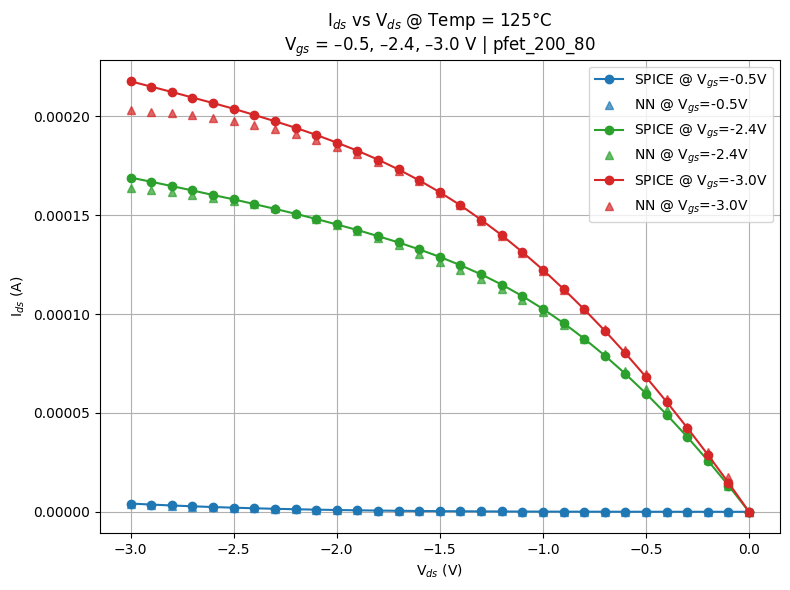

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


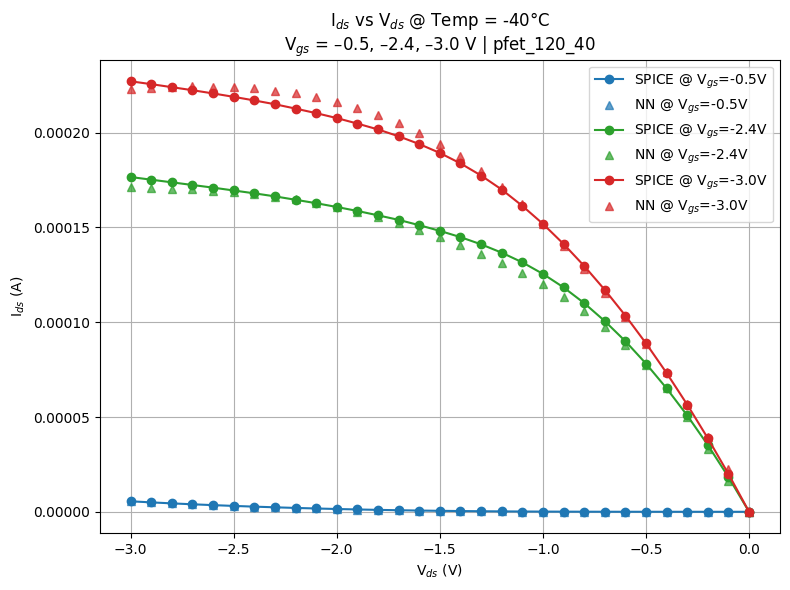

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


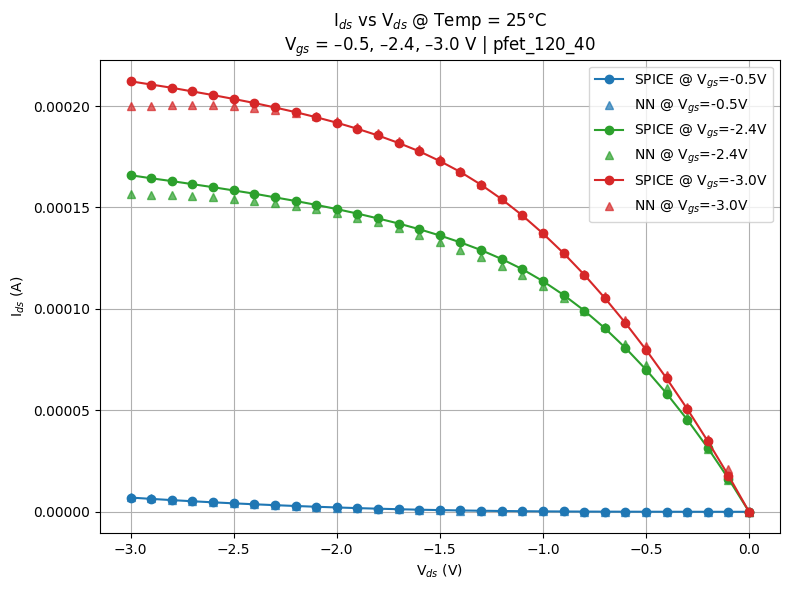

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


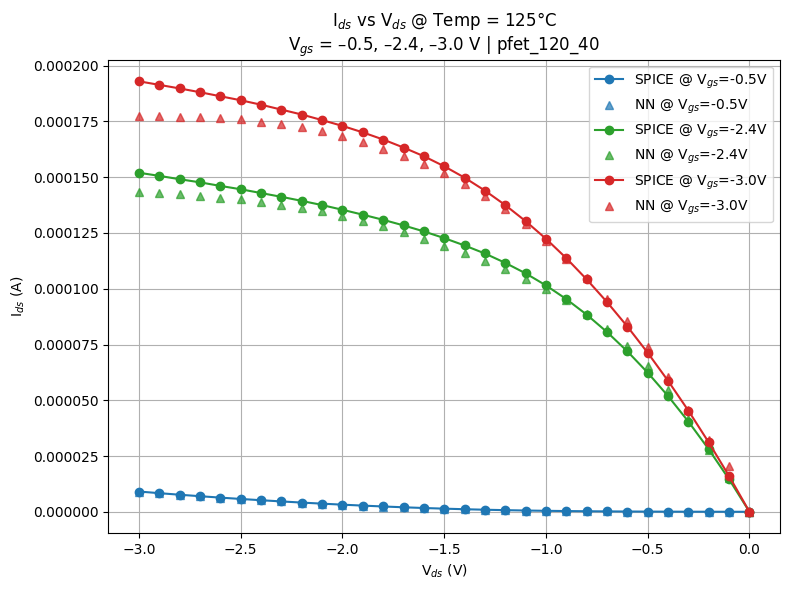

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


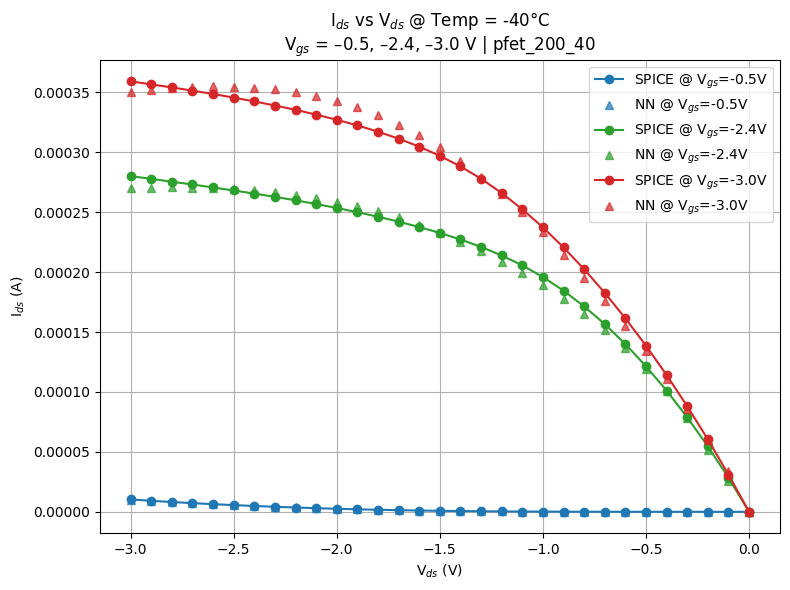

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


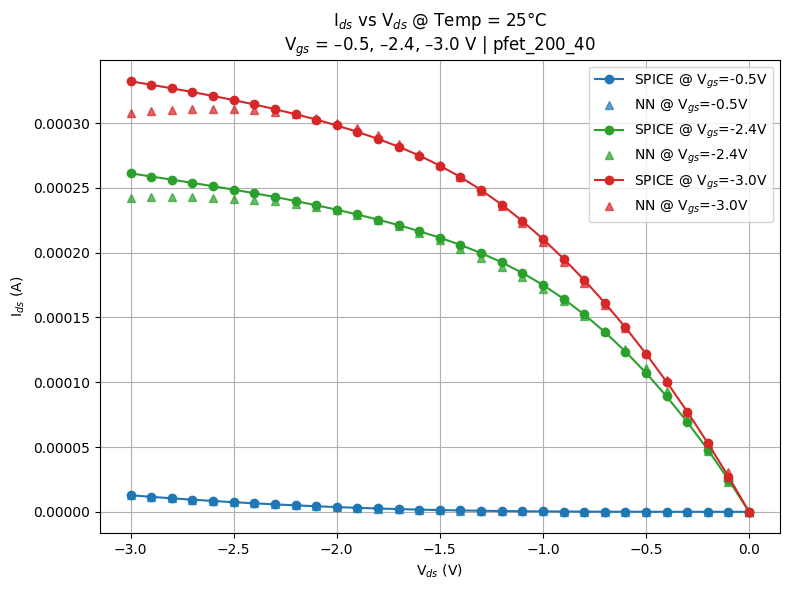

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


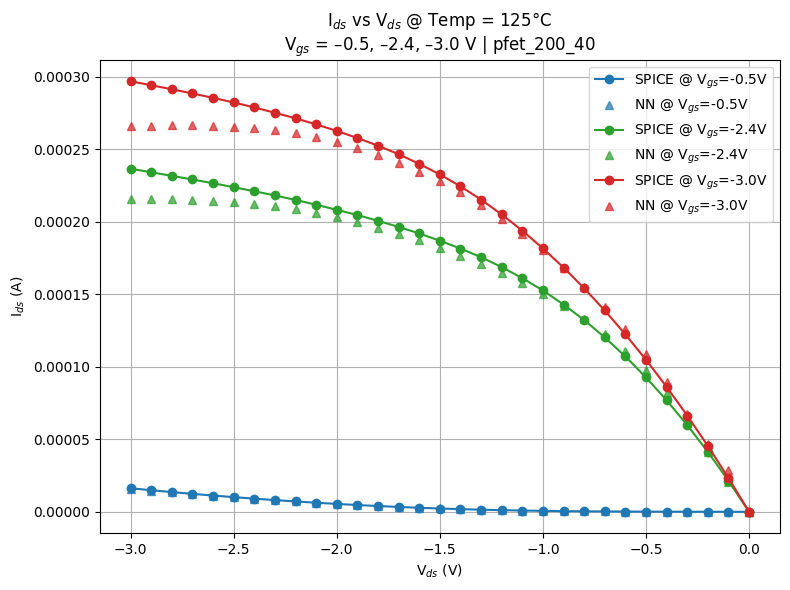

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


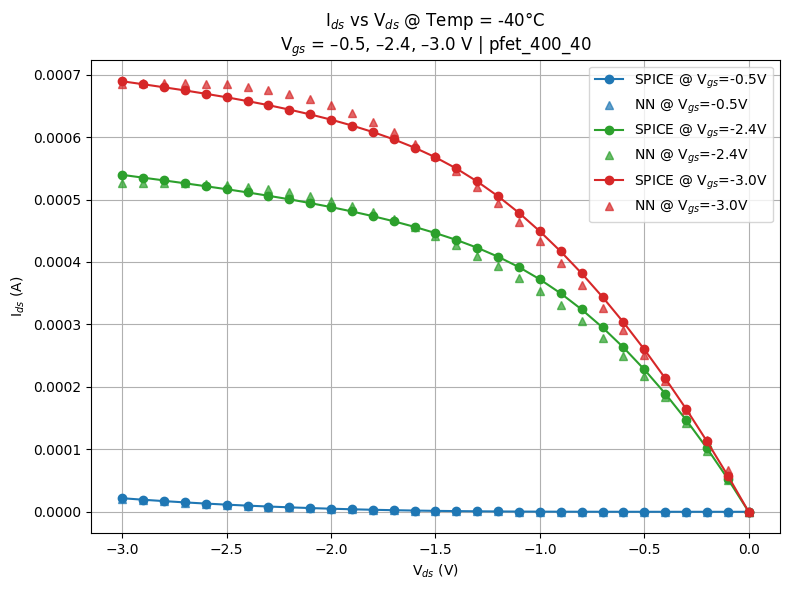

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


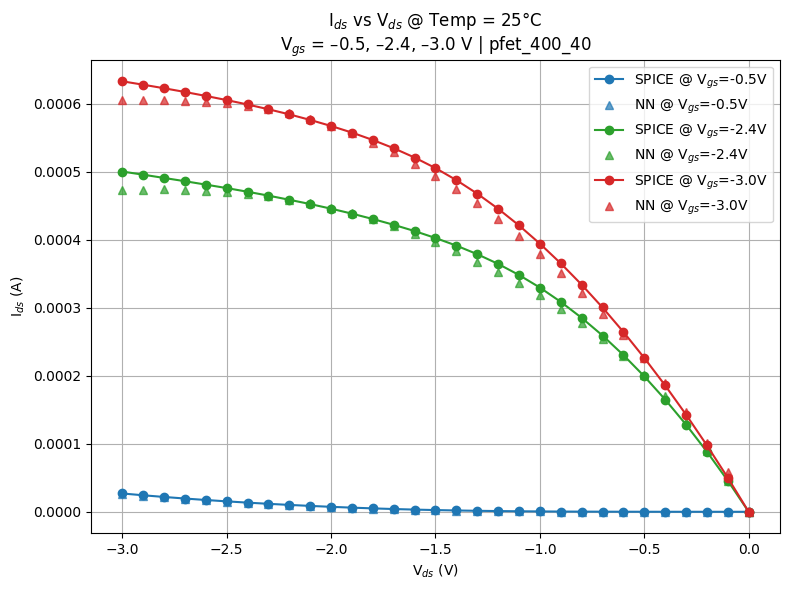

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


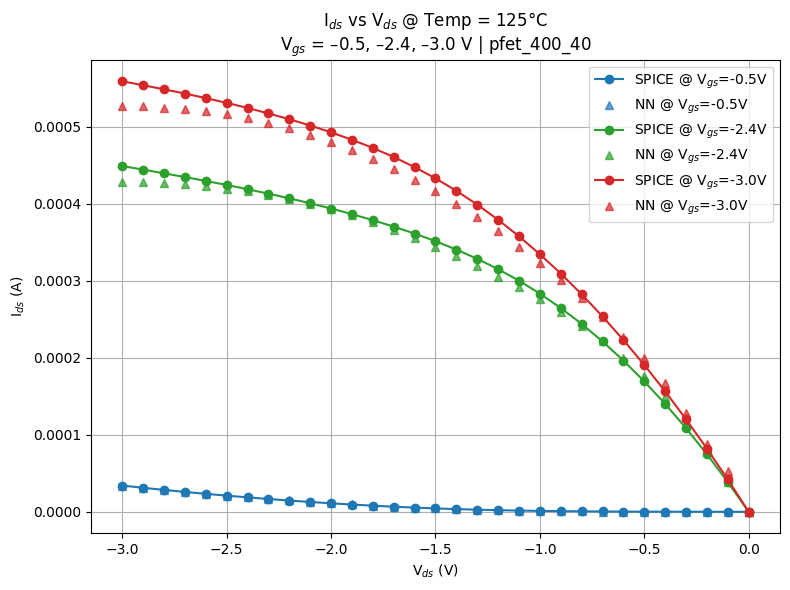

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


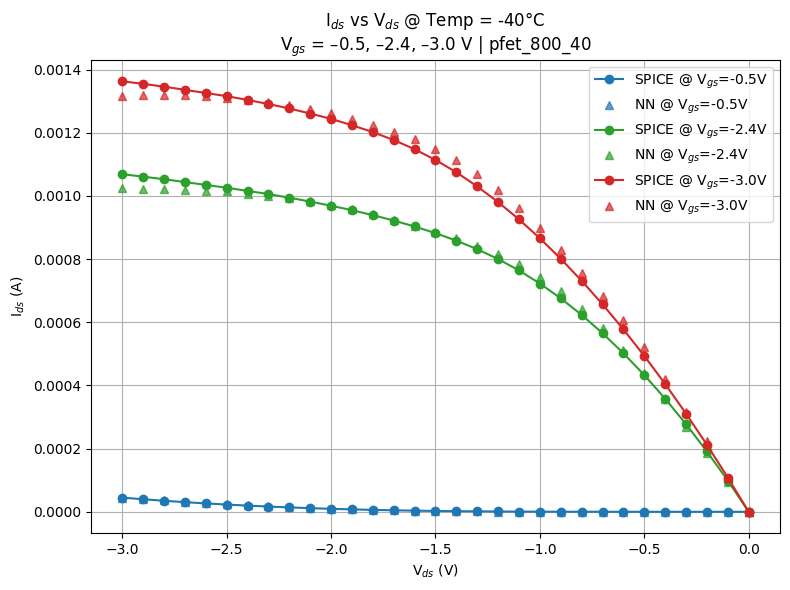

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


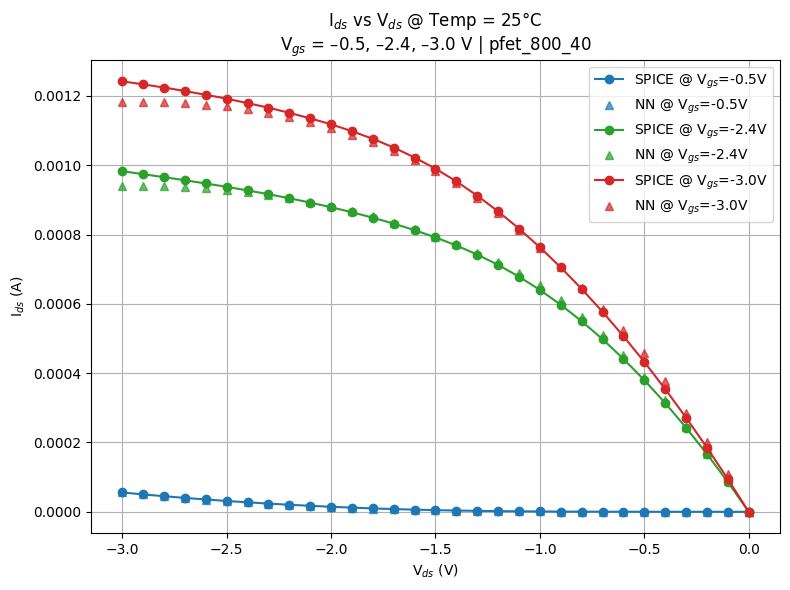

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


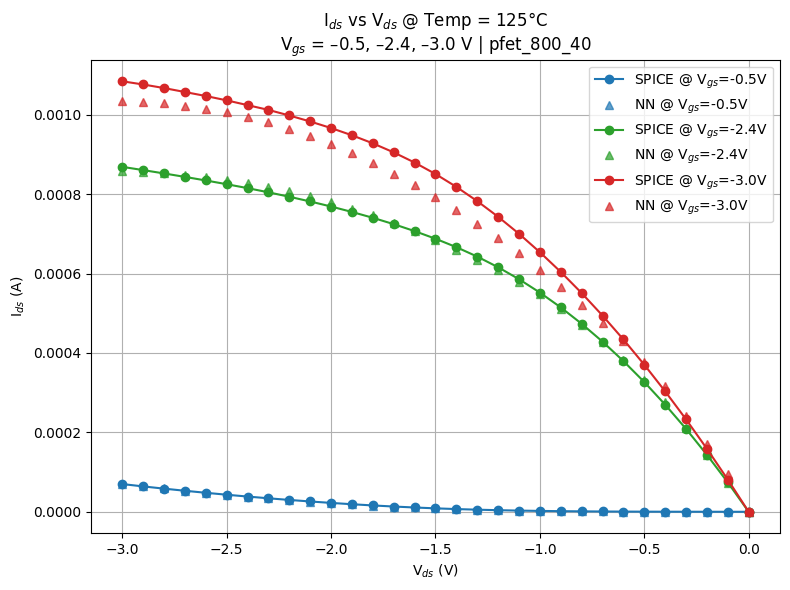

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


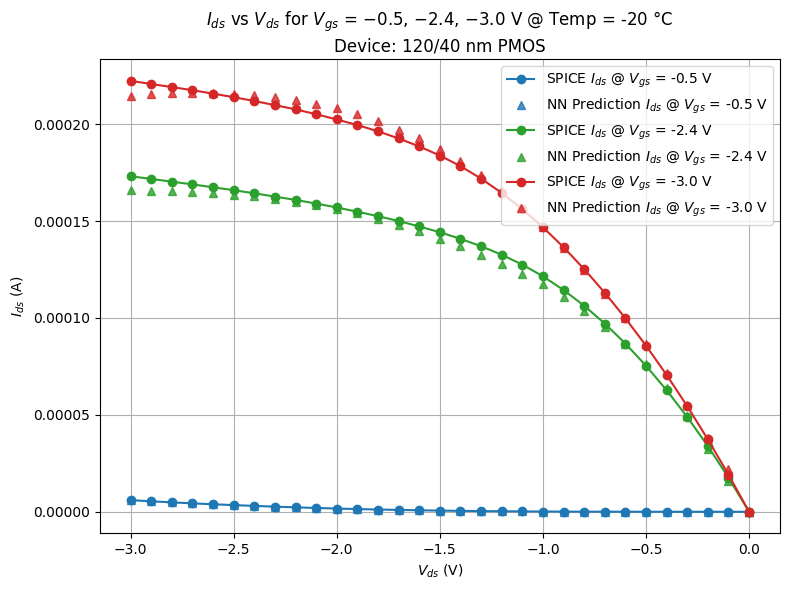

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


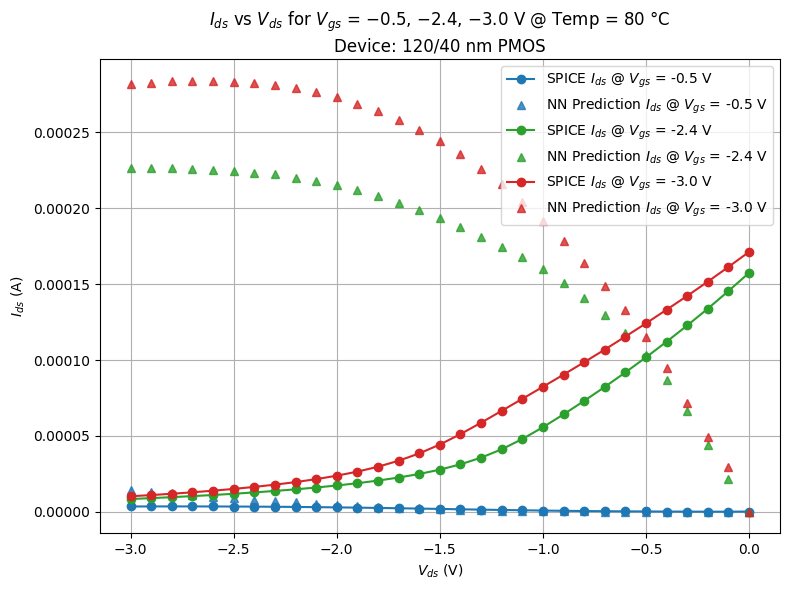

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


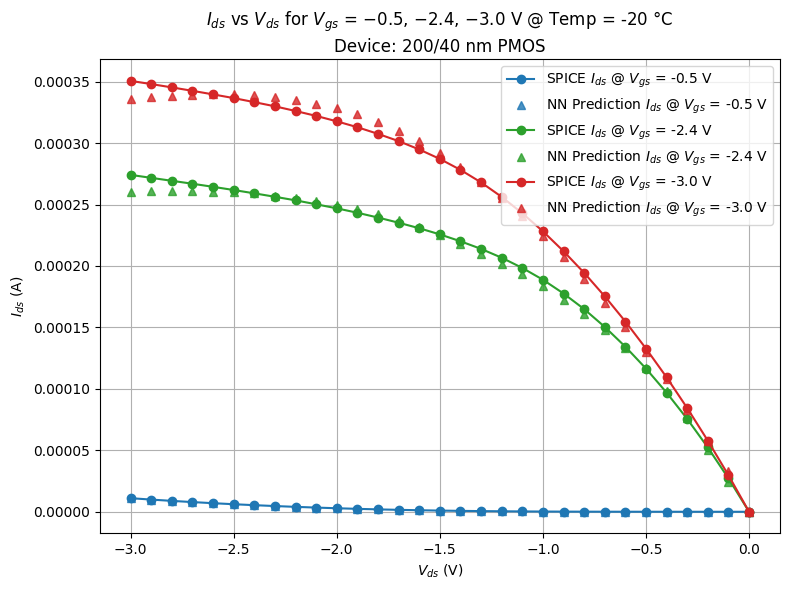

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


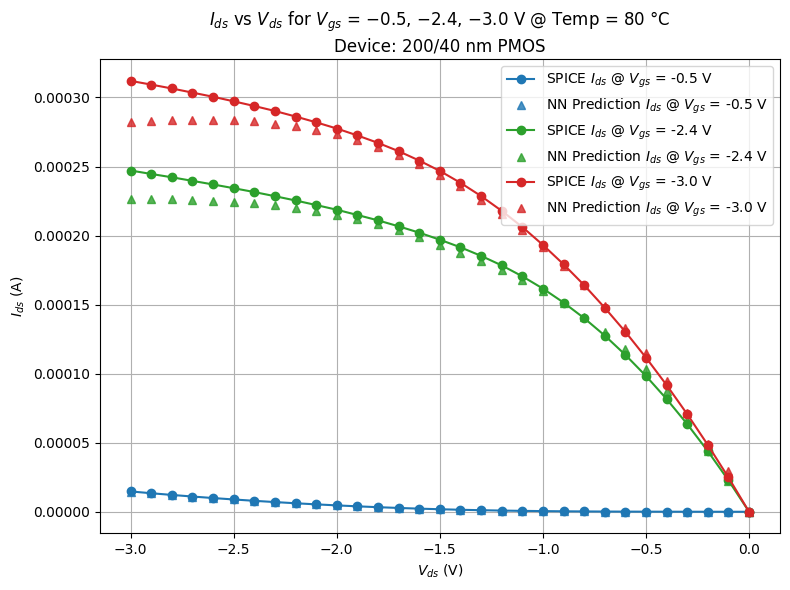

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


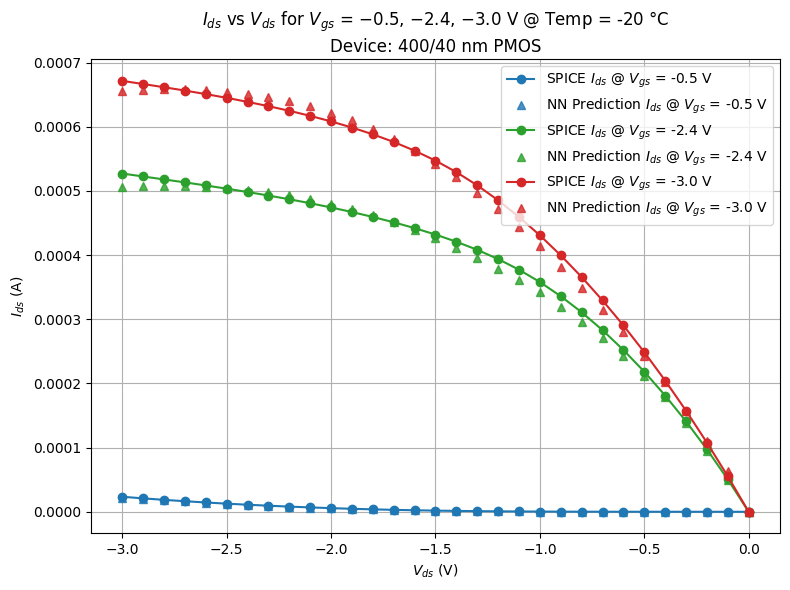

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


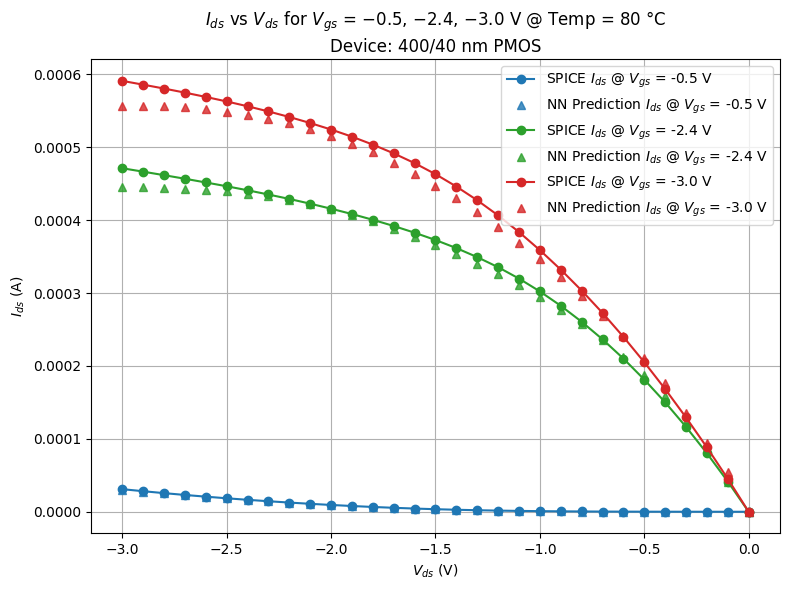

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


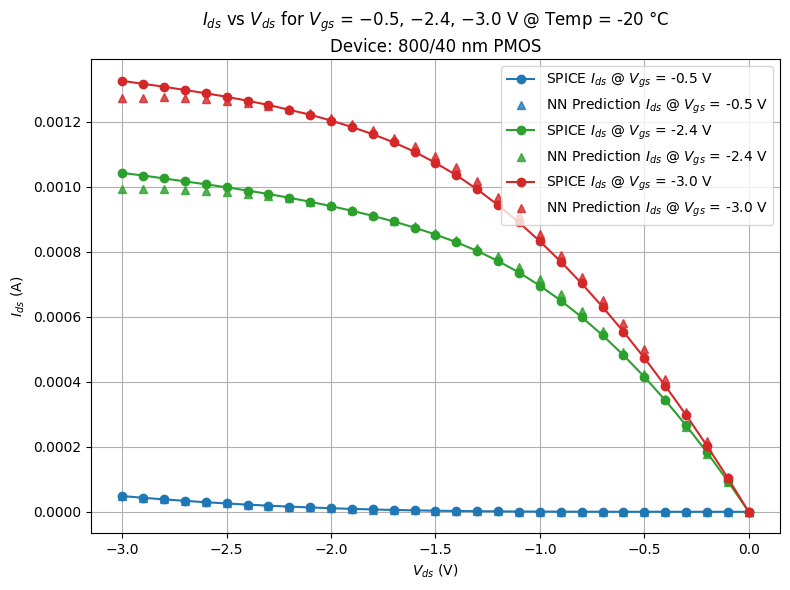

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


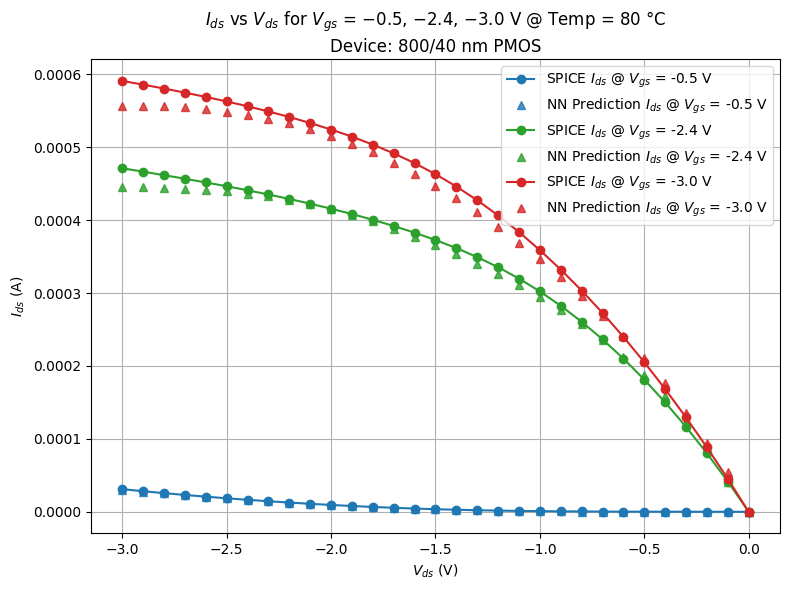

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
